In [3]:
import pandas as pd
import numpy as np
import statistics as stats # estadística
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [4]:
#levantamos la data con pandas
df = pd.read_csv("8&9 shallow.csv",  encoding="latin-1", delimiter=";")
df.head(10)

,date,shallow,hurrac
0,ene-17,1627,0
1,feb-17,1629,0
2,mar-17,1635,0
3,abr-17,1632,0
4,may-17,1644,0
5,jun-17,1636,1
6,jul-17,1618,1
7,ago-17,1572,1
8,sep-17,1380,1
9,oct-17,1561,1


**THE ESTIMATION IS SIMILAR TO SARIMA, SINCE WE NEED (pdq) (PDQ)**

**Time serie of oil production from "shallow waters" (aguas someas) in Mexico from january 2017 to april 2024 in (thousand barrels per day)**

Pemex wants to forecast the oil production from shallow waters. Also, it wants to know if the hurracane season from june to november would affect the forecast for the next 12 months.  

Exogenous variable: shallow (categorical variable (0,1) where 1= hurracane season , 0= no hurracane season


**1) STEP ONE: DECLARE TIME SERIES AND CLEAN IT**

In [5]:
#Create a dictionary to map the months
months = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr',
    'may': 'May', 'jun': 'Jun', 'jul': 'Jul', 'ago': 'Aug',
    'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Replace the spanish months to english
df['date'] = df['date'].str[:3].map(months) + df['date'].str[3:]

# turn date to datetime
df['date'] = pd.to_datetime(df['date'], format='%b-%y')

# Set date to index
df.set_index('date', inplace=True)
df.head()

,shallow,hurrac
date,,
2017-01-01,1627,0
2017-02-01,1629,0
2017-03-01,1635,0
2017-04-01,1632,0
2017-05-01,1644,0


In [6]:
df.describe()

,shallow,hurrac
count,88.000000,88.000000
mean,1389.068182,0.477273
std,113.912327,0.502346
min,1177.000000,0.000000
25%,1317.750000,0.000000
50%,1369.000000,0.000000
75%,1419.750000,1.000000
max,1644.000000,1.000000


In [7]:
df.isnull().sum()

shallow    0
hurrac     0
dtype: int64

In [8]:
# Separate endogenous and exogenous variables
endog = df['shallow']
exog = df[['hurrac']]

**Step 2) VISUALIZE OIL PRODUCTION DATA TO SEE TREND AND SEASONAL (Thousand barrels per day)***

Both variables endogenous and exogenous have sesonal effects

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

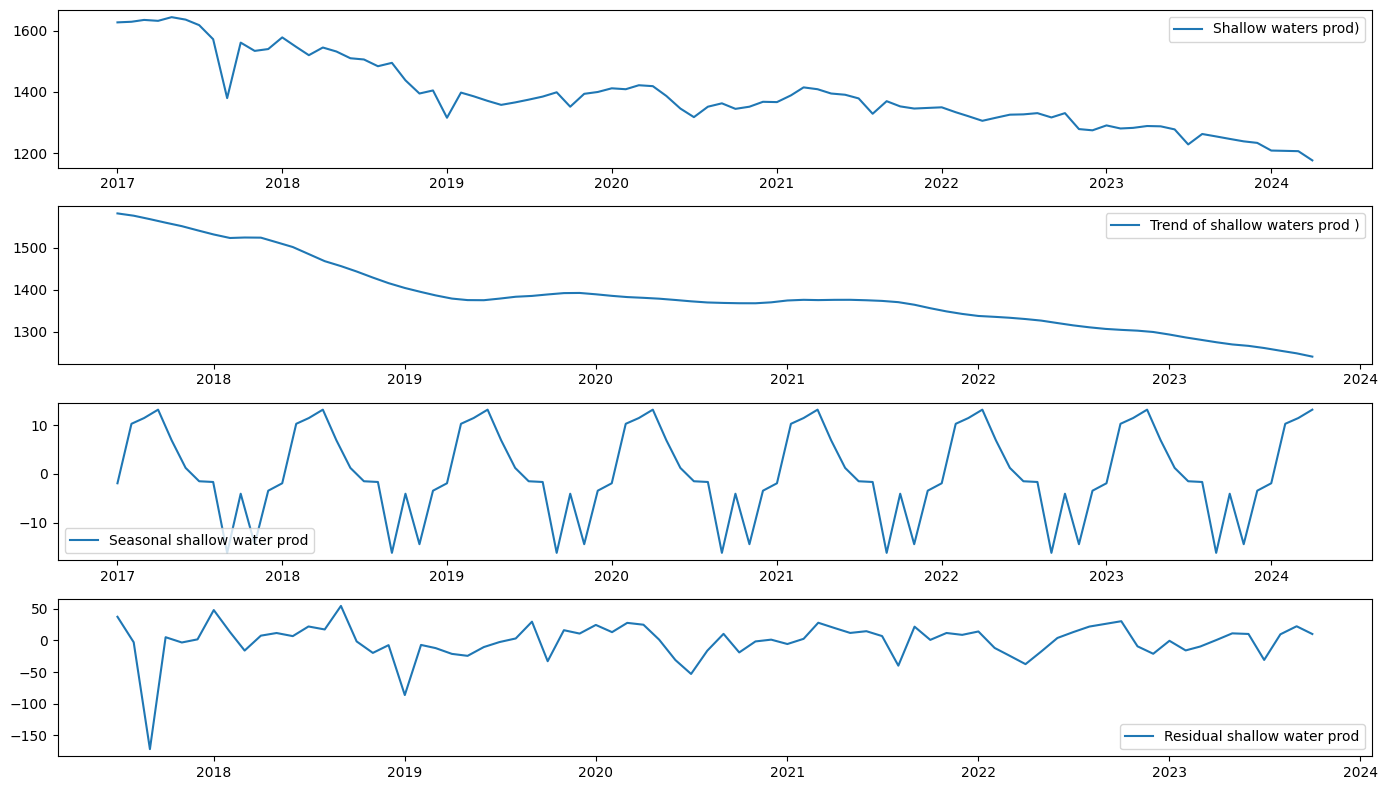

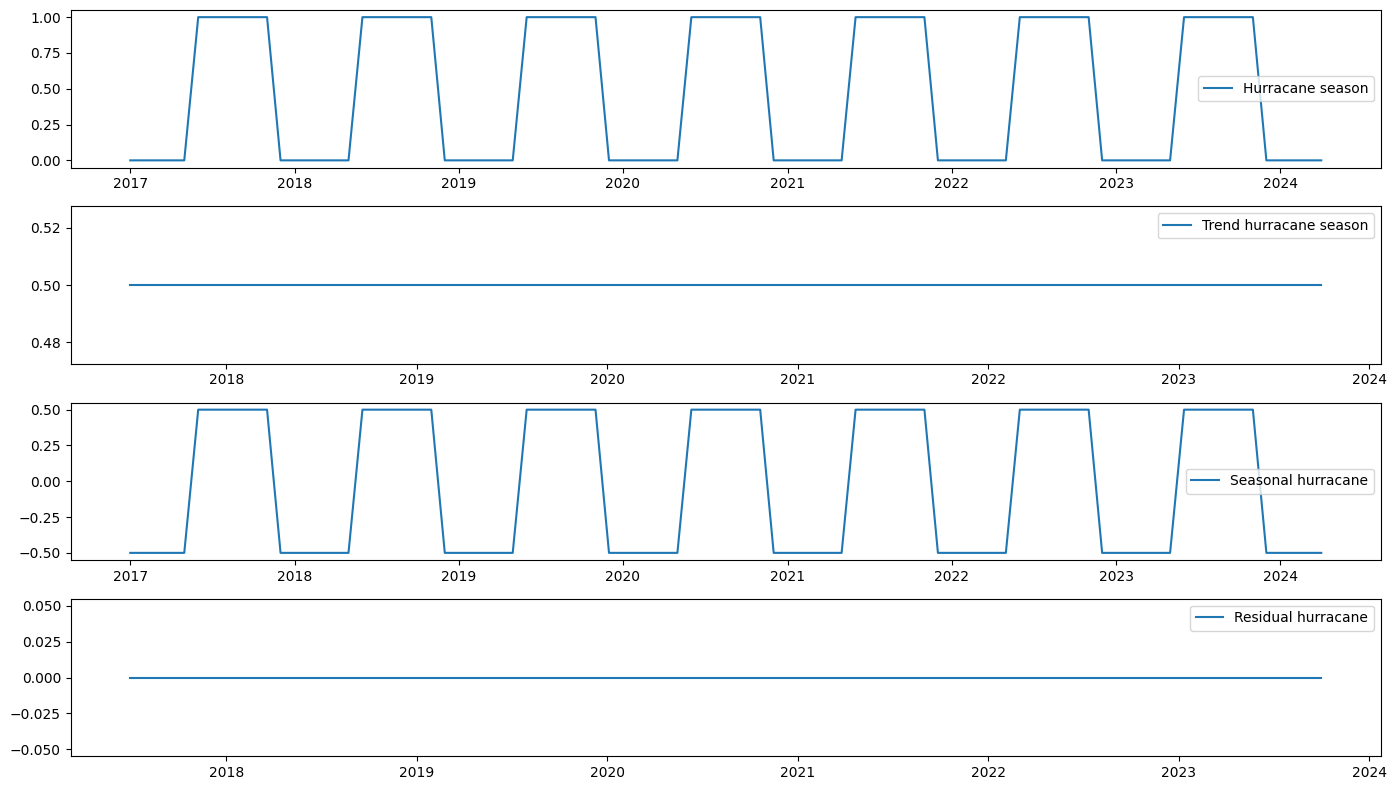

In [10]:
# Decompose the endogenous variable
decompose_endog = seasonal_decompose(endog, model='additive', period=12)
trend_endog = decompose_endog.trend
seasonal_endog = decompose_endog.seasonal
residual_endog = decompose_endog.resid

# Decompose the exogenous variable
decompose_exog = seasonal_decompose(exog, model='additive', period=12)
trend_exog = decompose_exog.trend
seasonal_exog = decompose_exog.seasonal
residual_exog = decompose_exog.resid

# Plot the components for the endogenous variable
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(endog, label='Shallow waters prod)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_endog, label='Trend of shallow waters prod )')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_endog, label='Seasonal shallow water prod')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_endog, label='Residual shallow water prod')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plot the components for the exogenous variable
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(exog, label='Hurracane season')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_exog, label='Trend hurracane season')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_exog, label='Seasonal hurracane')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_exog, label='Residual hurracane')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**3) CHECK STATIONARITY OF ENDOGENOUS VARIABLE "SHALLOW"**

In [11]:
# Separate endogenous and exogenous variables
endog = df['shallow']
exog = df[['hurrac']]


When the Test statistic is lower than crfitical value, the serie is stationary. P-value also should be lower than 0.05 to be stationary.

In [12]:
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(endog, autolag='AIC') ##endog=shallow
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.425014
p-value                         0.570227
#Lags Used                      1.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


So, the oil production of shallow waters  serie is non stationary, since -1.42 >-3.5, -2.8, -2.58 :-(


**4 CALCULATE AND VISUALIZE ACF (Autocorrelation function) & PARF (Partial autocorrelation function)** Determine (pdq) (PDQm)

We can see that:

MA(q)- ACF (nearly zero)= 23 or 24 lags

AR (p)-PACF (blue area- below the blue threshold)= 9-10

P=2(Number of spikes outside the dense blue part until 12 months)
Q=5 (Number of spikes inside the blue before 12 months





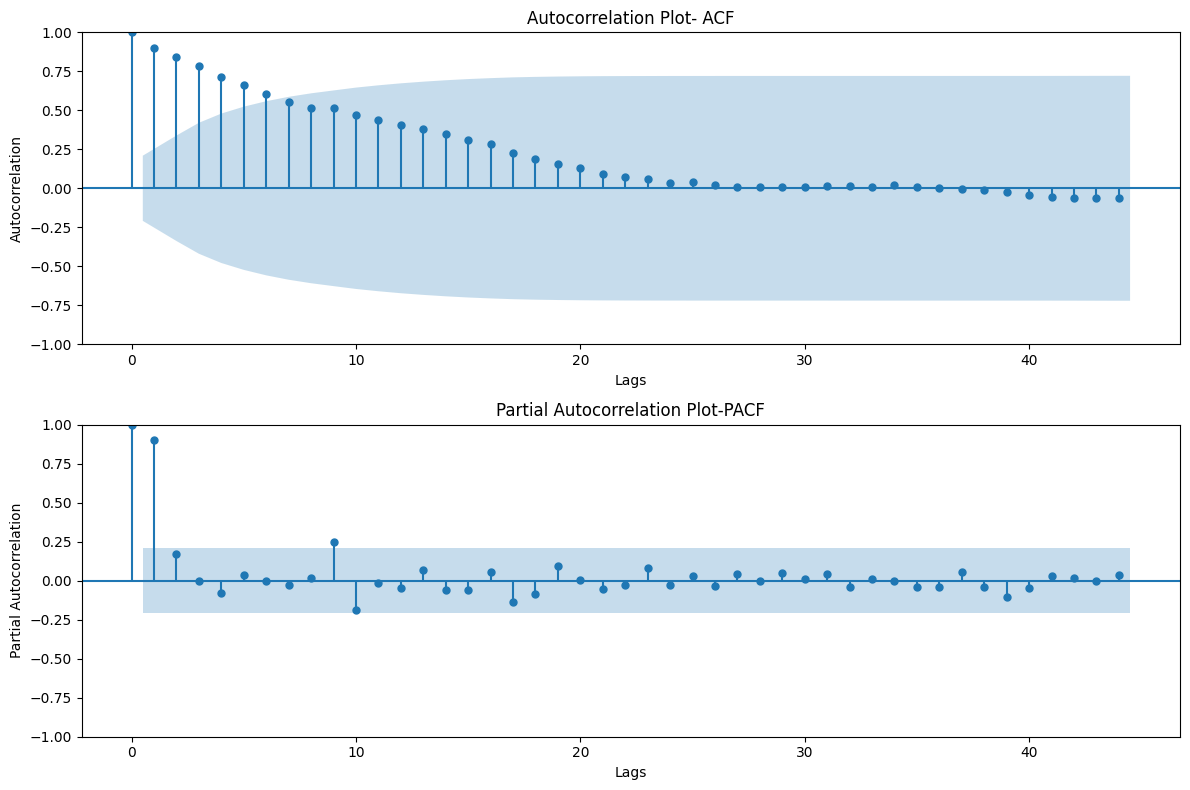

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Select column
shallow_prod= df['shallow']

# Create subgraph figures
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot autocorrelation (MA(ACF))
plot_acf(shallow_prod, ax=axes[0], lags=44)
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')
axes[0].set_title('Autocorrelation Plot- ACF')

# Plot partial autocorrelation (AR(PACF))
plot_pacf(shallow_prod, ax=axes[1], lags=44)
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].set_title('Partial Autocorrelation Plot-PACF')

# Adjust spaces
plt.tight_layout()

# Show figure
plt.show()


In [14]:
# Define the order and seasonal order (adjust parameters as needed)
order = (9, 1, 11) #(pdq). Although the real order is (9,1,23), we reduce the use of lags in"q" (ACF), because it causes problems in the model.
seasonal_order = (2, 1, 5, 12)  # Assuming monthly seasonality: Count the number of spikes in first 12 lags (PDQM)

In [15]:
# Fit the SARIMAX model
sarimax_model = sm.tsa.SARIMAX(endog, order=order, seasonal_order=seasonal_order, exog=exog).fit(disp=False)

# Print model summary
print(sarimax_model.summary())

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for varia

                                             SARIMAX Results                                             
Dep. Variable:                                           shallow   No. Observations:                   88
Model:             SARIMAX(9, 1, 11)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -380.575
Date:                                           Tue, 16 Jul 2024   AIC                            819.149
Time:                                                   11:25:46   BIC                            886.356
Sample:                                               01-01-2017   HQIC                           845.984
                                                    - 04-01-2024                                         
Covariance Type:                                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [16]:
# Forecast the next 12 periods
# Prepare future values of exogenous variables for the forecast period
# exog_future_data = your_future_exogenous_variables_data
exog_future_data = pd.DataFrame({'hurrac'})

We put manually the expected data of the exogenous variable

In [17]:
# Get forecast: REMEMBER TO PUT MANUALLY THE EXPECTED DATA OF THE EXOGENOUS VARIABLE FOR THE NEXT 12 MONTHS AS AN EXAMPLE
forecast_steps = 12
sarimax_forecast = sarimax_model.get_forecast(steps=forecast_steps, exog=[0,1,1,1,1,1,1,0,0,0,0,0])
forecasted_values = sarimax_forecast.predicted_mean

In [18]:
# Print the forecasted values
print("Forecasted Values:")
print(forecasted_values)

Forecasted Values:
2024-05-01    1174.952661
2024-06-01    1196.796239
2024-07-01    1185.515185
2024-08-01    1188.335889
2024-09-01    1135.694965
2024-10-01    1174.212119
2024-11-01    1152.343258
2024-12-01    1154.756926
2025-01-01    1178.549501
2025-02-01    1186.921270
2025-03-01    1197.650511
2025-04-01    1193.159694
Freq: MS, Name: predicted_mean, dtype: float64


**Visualization of forecast**

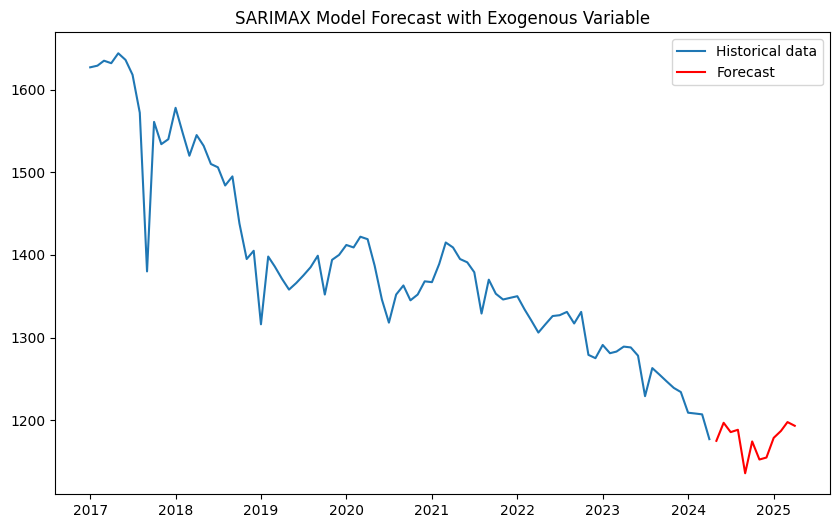

In [19]:
# Visualize the forecast
plt.figure(figsize=(10, 6))
plt.plot(endog, label='Historical data')
plt.plot(forecasted_values, label='Forecast', color='red')
plt.legend(loc='best')
plt.title('SARIMAX Model Forecast with Exogenous Variable')
plt.show()